# Миролим Сайдахматов

Для начала подготавливаем систему для работы: импорт библиотек, настройка драйвера и т.п.

In [1]:
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip install webdriver-manager
#pip install webdriver-manager --upgrade
#pip install packaging

In [3]:
driver = webdriver.Chrome(ChromeDriverManager().install())

Переходим по ссылке и на самом сайте настроиваем фильтр так, как нам необходимо. В поисковой строке вбиваем "игра", выбираем период за какое время нам нужно собрать статьи. Во благо, всё это сохраняется в адресной строке, копируем её и сохраняем как переменную.

In [4]:
url_to_dzen = 'https://dzen.ru/news/search?issue_tld=kz&text=%D0%B8%D0%B3%D1%80%D0%B0+date%3A20230902..20231002&filter_date=1693591200000%2C1696183200000&flat=1&sortby=date'

Эмулируем движения человека для просмотра больше статьей на странице. Для этого запускаем драйвер.

In [5]:
driver.get(url_to_dzen)

Находим там кнопку "Больше новостей" и копируем её селэктор. По циклу прооняем и эмулируем нажатия этой кнопки используя Selenium.

In [6]:
btn_selector = "#neo-page > div.neo-app.news-app.news-app_dzen.news-app_redesigned > div > div.news-app-layout__menu-content-wrapper.news-app-layout__menu-content-wrapper_with-redesigned-header > div.news-app-layout__content-and-rubric.news-app-layout__content-and-rubric_with-new-layout > div.news-app__content.news-app__content_with-new-layout > div.mg-grid__row.mg-grid__row_gap_8.news-search__content > div > div > div.mg-grid__col.mg-grid__col_xs_8.news-search__results-col > div > div.mg-load-more.news-search__next-button > button"
expand_btn = driver.find_element(By.CSS_SELECTOR, btn_selector)

try:
    while expand_btn:
        expand_btn.click()
        driver.implicitly_wait(100)
        expand_btn = WebDriverWait(driver, 100).until(EC.visibility_of_element_located((By.CSS_SELECTOR, btn_selector)))
        
except TimeoutException:
    print('Finished')
    pass

Finished


Как только заканчивается прокрутка по сайту, то есть исчезает кнопка расширения мы остановили цикл и теперь можно переходить к содержимому.

In [7]:
content = driver.page_source

In [8]:
soup = BeautifulSoup(content, "lxml")

Находим все артикли(тэги).

In [9]:
articles = soup.find_all('article', class_="news-search-story news-search__main-item mg-grid__item")
len(articles)

200

In [10]:
articles[0]

<article class="news-search-story news-search__main-item mg-grid__item"><div class="mg-snippet mg-snippet_flat news-search-story__snippet"><span aria-label="Источник: РГВК Дагестан" class="mg-favorites-dot__indicator mg-favorites-dot__indicator_size_xl mg-snippet__image mg-snippet__image_type_logo"><div class="mg-favorites-dot__image mg-snippet__src"><img alt="" class="neo-image neo-image_loaded" height="30" loading="lazy" src="https://avatars.dzeninfra.ru/get-ynews-logo/135513/254068280-1644309692243-square/logo-square" width="30"/></div></span><div class="mg-snippet__wrapper"><div class="mg-snippet__content"><h3 class="mg-snippet__url-wrapper"><a class="mg-snippet__url" data-log-id="u-1696244222000-mvivqd5s76-3" href="https://rgvktv.ru/news/sport/makhachkalinskoe-dinamo-vyigryvaet-v-gostyakh-u-eniseya02102023/?utm_source=yxnews&amp;utm_medium=desktop&amp;utm_referrer=https%3A%2F%2Fdzen.ru%2Fnews%2Fsearch%3Ftext%3D" rel="noopener" target="_blank"><div class="mg-snippet__title"><span r

In [11]:
for art in articles[0]:
    topic = art.find('h3', class_="mg-snippet__url-wrapper")#.text.strip()
    link = topic.find('a', class_="mg-snippet__url")['href']#.text.strip()
    description = art.find('span', class_="mg-snippet__text").text.strip()
    source = art.find('span', class_="mg-snippet-source-info__agency-name").text.strip()
    datetime = art.find('span', class_="mg-snippet-source-info__time").text.strip()

In [12]:
print(topic.text.strip())
print(link)
print(description)
print(source)
print(datetime)

Махачкалинское «Динамо» выигрывает в гостях у «Енисея»
https://rgvktv.ru/news/sport/makhachkalinskoe-dinamo-vyigryvaet-v-gostyakh-u-eniseya02102023/?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fdzen.ru%2Fnews%2Fsearch%3Ftext%3D
Красноярске прошёл матч 12 тура Чемпионата России по футболу в ФНЛ. Вся игра проходила с переменным успехом. Отличиться смогли гости лишь под занавес встречи. Зелимхан Юсупов со штрафного навесил мяч, а Сердер Сердеров ударом головы сумел поразить ворота хозяев поля. Забитый мяч стал единственным в этой встрече, и подопечные Курбана...
РГВК Дагестан
16:50


Теперь будем сохранять содержимое страницы в отдельные колонны как ниже.

In [13]:
scraped_data = [] 

In [14]:
for art in articles:
    topic = art.find('h3', class_="mg-snippet__url-wrapper")#.text.strip()
    link = topic.find('a', class_="mg-snippet__url")['href']#.text.strip()
    topic = topic.text.strip()
    description = art.find('span', class_="mg-snippet__text").text.strip()
    source = art.find('span', class_="mg-snippet-source-info__agency-name").text.strip()
    datetime = art.find('span', class_="mg-snippet-source-info__time").text.strip()
    
    temp_dict = {
        'Topic' : topic,
        'Link' : link,
        'Description' : description,
        'Source' : source,
        'Datetime' : datetime
    }
    
    scraped_data.append(temp_dict)

In [15]:
driver.quit()

Переводим в формат Pandas.DataFrame.

In [16]:
df = pd.DataFrame(scraped_data)

In [17]:
df.head()

,Topic,Link,Description,Source,Datetime
0,Махачкалинское «Динамо» выигрывает в гостях у ...,https://rgvktv.ru/news/sport/makhachkalinskoe-...,Красноярске прошёл матч 12 тура Чемпионата Рос...,РГВК Дагестан,16:50
1,Payday 3 успело опробовать более 3 миллиона по...,https://lvgames.info/2023/10/02/payday-3-uspel...,...к негативном отношению к игре со стороны со...,LVGames.info,16:49
2,Пензенский «Зенит» одержал победу в матче прот...,https://russia58.tv/news/657140/?utm_source=yx...,Пензенский футбольный клуб «Зенит» одержал поб...,ГТРК Пенза,16:41
3,Роднина: «Россия будет поддерживать спортсмено...,https://www.sport.ru/figurnoe_katanie/rodnina-...,"...катанию, а ныне Ирина Роднина заявила, что ...",Sport.ru,16:38
4,Илья Ковальчук примет решение по продолжению к...,https://tass.ru/sport/18891349?utm_source=yxne...,"МОСКВА, 2 октября. / ТАСС/. Чемпион Олимпийски...",ТАСС Спорт,16:36


Устанавливаем стоп-слова(слова часто встречающиеся но не имеющие смыслового значения как предлоги и т.п.), но это нам вообще не нужно так как все слова на русском а стоп-слова на английском. Указываем нужную нам колонну (Description - описание) в нашем случае и рисуем наш WordCloud.

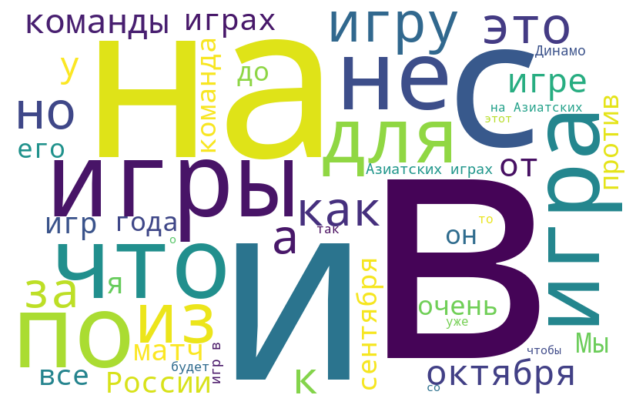

In [18]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color='white', width=800, height=500)

text = " ".join(text for text in df.Description)

wordcloud.generate(text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Выше результат. Конец.